# Gas station prediction

## Introduction/Business Problem

Gas stations are required throughout the city to supply fuel for transportation. They can often be found in dense retail sectors that have a variety of other venues present within a certain radius. Furthermore, you often see different companies opening gas stations in close approximation to each other.  

The problem is, how many gas stations are typically built to meet the needs of the community? This is a crucial problem for not only gas companies but also city planning. Allowing too many gas stations results in less area for local businesses to open their stores. The stations also have negative impacts on the environment as the sites they are built on cannot be used after the gas station is removed. Therefore, it would be beneficial to predict how many gas stations are typically built in any given area so that it can inform future design and build recommendations. (https://www.theglobeandmail.com/report-on-business/industry-news/property-report/life-after-corner-gas-the-challenges-of-developing-old-service-stations/article32219739/)  

Ottawa, ON Canada is going to be used as the test city as it has a variety of different retail spaces and city densities that can be a good representation of how gas stations are distributed.





## Data

The data that’s going to be used is primarily the Foursquare API data. First the location and label of the venues will be used to identify gas stations using the venues search endpoint and limiting the category. Secondly the other venues in the area will be identified grouped by their and counted.  Secondly, population data at an FSA (forward station area) level will be used. This data will be collected from Statistics Canada ( Example can be found here: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&S=22&O=A). The longitude and latitude of the FSAs will be acquired through the method used in the previous project using the geocoder package.

For each gas station in Ottawa, the number of gas stations located within a 2km radius will be identified and used as the dependent variable. The population of the gas station will be the total population of every FSA within a 2km radius. Similarly, only the other venues within a 2km radius will be used as predictors. 

After the data is gathered and prepared a variety of regression based models will be used to predict the number of surrounding gas stations with the collected data. 


### Example of Foursquare API result.
#### Category data will be used in the analysis

In [10]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
#Set request parameters
CLIENT_ID = 'D2CKJKGH5FB0CCTRQNUHPTYJTZNJLZCVKPUDDO5UACTUF3NK'
CLIENT_SECRET = 'QD14BR5AFKUH1Q5A3F303ZRIE1I0KXIZLVTVJA305V1MNFAH'
VERSION = '20200601'
LIMIT = 100
gas_station_id = '4bf58dd8d48988d113951735'
city = 'Ottawa, ON'
limit = 50
nw = (45.390671, -76.097741)
nn = (45.380876, -75.799434)
ne = (45.423567, -75.469810)
se = (45.218942, -75.550669)
ss = (45.111716, -75.838242)
grid_search = [nw,nn,ne,se,ss]


Using Google Maps

In [11]:
result = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_K')
bs = BeautifulSoup(result.content,"lxml")
fsa_city = []
for i in bs.find_all("td"):
    try:
        fsa_city.append((i.find_all("b")[0].text.strip(),i.find_all("b")[1].text.strip()))
    except IndexError as e:
        continue
fsa_city = pd.DataFrame(fsa_city,columns=["FSA","City"]).iloc[1:,:]
fsa_city.head()

,FSA,City
1,K2A,Ottawa
2,K4A,Ottawa
3,K1B,Ottawa
4,K2B,Ottawa
5,K4B,Ottawa


In [168]:
#First Resulting gas stations
result_columns = ["venue_id","venue_name","lat","lng","postal_code",'city',"category"]
def string_value_check(r,value):
    try:
        return r[value]
    except KeyError:
        return "None"

def extract_venue_info(results):
    venue_raw = [
        
           (r['venue']['id'],
            r['venue']['name'],
            r['venue']['location']['lat'],
            r['venue']['location']['lng'],
            string_value_check(r["venue"]["location"],"postalCode"),
            string_value_check(r["venue"]["location"],"city"),
            r['venue']['categories'][0]['name']
            )
         for r in results['response']['groups'][0]['items']
            ]
    return pd.DataFrame(venue_raw,columns=result_columns)

initial_gas_stations = pd.DataFrame(columns=result_columns)

for lat, lng in grid_search:
    RADIUS = 25000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&limit={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat,
            lng,
            gas_station_id,
            limit,
            RADIUS
            )
    initial_gas_stations = initial_gas_stations.append(extract_venue_info(requests.get(url).json()))
initial_gas_stations = initial_gas_stations.drop_duplicates()
initial_gas_stations.city.drop_duplicates()

0                 Carp
1               Ottawa
2               Kanata
4             Dunrobin
9             Gatineau
13         Stittsville
17                None
19            Arnprior
23              Nepean
39           Luskville
45             Almonte
46     Ottawa Division
19              Aylmer
0           Cumberland
2              Orléans
8           Gloucester
16    Carlsbad Springs
29                Vars
38              Vanier
7             Metcalfe
31           Barrhaven
1             Richmond
3       Carleton Place
16          Kemptville
Name: city, dtype: object

In [212]:
city_filter = (initial_gas_stations.postal_code.str[:3].isin(fsa_city.FSA))|(initial_gas_stations.city=="Ottawa")
initial_gas_stations = initial_gas_stations.loc[city_filter]
initial_gas_stations.head()

,venue_id,venue_name,lat,lng,postal_code,city,category
1,4b2b8249f964a520f8b624e3,Ralph & Son's,45.352134,-75.835712,None,Ottawa,Diner
2,4b26a38df964a520cd7e24e3,Shell,45.350954,-75.926538,K2K 2R9,Kanata,Gas Station
3,4b666374f964a520da1f2be3,Esso,45.342269,-75.917041,K2K 2M5,Ottawa,Gas Station
4,4c63230fde1b2d7f490be470,MacEWEN Gas,45.383418,-75.969626,K2K 1X7,Dunrobin,Gas Station
5,4c78288d81bca0930328f914,Petro-Canada,45.308107,-75.915422,K2T 1L2,Kanata,Gas Station


In [213]:
nearby_stations = pd.DataFrame(columns=result_columns+["station_id"])

def get_nearby_gas_stations(station_id,lat,lng):
    RADIUS = 2000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&limit={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat,
            lng,
            gas_station_id,
            limit,
            RADIUS
            )
    results = requests.get(url).json()
    near_gas_stations = extract_venue_info(results)
    near_gas_stations["station_id"] = [station_id]*near_gas_stations.shape[0]
    return near_gas_stations

#Find the nearby gas stations for each of the initial gas stations
for i,s in initial_gas_stations.iterrows():
    nearby_stations = nearby_stations.append(get_nearby_gas_stations(s["venue_id"],s["lat"],s["lng"]))

In [214]:
unchecked_stations = nearby_stations.loc[nearby_stations.venue_id.isin(nearby_stations.station_id) == False]
unchecked_stations[result_columns].drop_duplicates()
for I in range(10):
    num_unchecked = unchecked_stations.shape[0]
    if num_unchecked != 0:
        print("Unchecked stations left: {}".format(num_unchecked))
        for i,s in unchecked_stations.iterrows():
            nearby_stations = nearby_stations.append(get_nearby_gas_stations(s["venue_id"],s["lat"],s["lng"]))
            
        unchecked_stations = nearby_stations.loc[nearby_stations.venue_id.isin(nearby_stations.station_id) == False]
        unchecked_stations[result_columns].drop_duplicates()



Unchecked stations left: 221
Unchecked stations left: 1


In [227]:
nearby_stations = nearby_stations.drop_duplicates()
nearby_station_count = nearby_stations.groupby("station_id")["venue_id"].count().reset_index()
nearby_station_count["venue_id"] = nearby_station_count["venue_id"] -1
nearby_station_count.describe()

,venue_id
count,191.000000
mean,5.471204
std,2.779238
min,0.000000
25%,3.000000
50%,6.000000
75%,7.000000
max,14.000000


## Gas Station Count Distribution analysis
### Since we are measuring the number of gas stations in a fixed area. Our data may follow a poisson distribution. 

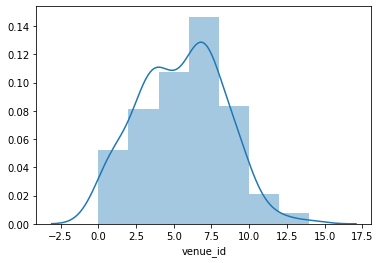

In [237]:
sns.distplot(nearby_station_count.venue_id,bins=7)

#### The distribution has a non zero right skewed distribution characteristic of a poisson distribution. Lets do a QQ-plot to see if the data lines up to the expected quiantiles

((array([ 0.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
          2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
          3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
          4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
          4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
          4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
          5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
          5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,
          6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
          6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
          6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
          7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  8.,
          8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
          8.,  8.,  9.,  9.,  9.,  9.,

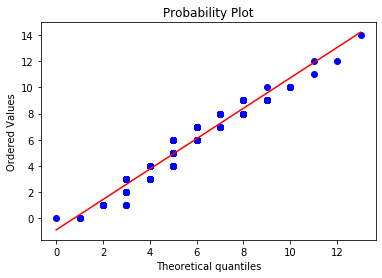

In [238]:
import scipy.stats as stats
stats.probplot(nearby_station_count.venue_id,nearby_station_count.venue_id.mean(),dist="poisson",plot=plt)

### The QQ-Plot is suggesting a poisson as well.
To check its statistical significance, I did a Kolmogorov-Smirnov test for goodness of fit

In [239]:
stats.kstest(nearby_station_count.venue_id,"poisson",args=[nearby_station_count.venue_id.mean()])

KstestResult(statistic=0.22663863523539407, pvalue=4.198366184302112e-09)

P Value is very significant. I am quite confident that this data follows a poisson distribution which is an expected but interesting discovery and could inform how we model this relationship in the future. 

## Population

## To incorperate the populate of the 

In [6]:

url = r"https://www.freemaptools.com/ajax/ca/get-canadian-postcodes-inside-radius.php?radius=2&showfsa=false&lat=51.06901665960392&lng=-93.33984375000001"
requests.get(url).text

''

In [20]:
fsa_pop

url = "https://www.freemaptools.com/ajax/ca/get-canadian-postcodes-inside-radius.php?radius=2&showfsa=true&lat=45.352134&lng=-75.835712&rn=5842"

headers= {"Connection": "keep-alive",
"Accept":"text/xml",
"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36",
"X-Requested-With": "XMLHttpRequest",
"Sec-Fetch-Site": "same-origin",
"Sec-Fetch-Mode": "cors",
"Sec-Fetch-Dest": "empty",
"Referer": "https://www.freemaptools.com/find-canada-postcodes-inside-radius.htm",
"Accept-Language": "en-US,en;q=0.9",
"Cookie": "PHPSESSID=dcda0f73d2aa8ba5bf8b217a1c950199; __gads=ID=75d3ef6ea8f9157b:T=1591669773:S=ALNI_MZI9OBOBl0cLgPqo-IVookVqmE4EA; _ga=GA1.2.1163297187.1591669773; _gid=GA1.2.1918753602.1591669773; _gat=1"
}fsa

bs = BeautifulSoup(requests.get(url,headers=headers).text)
fsas = [i["postcode"] for i in bs.find_all("postcodes")[0].find_all("postcode")]


TypeError: list indices must be integers or slices, not str

['K1Y', 'K2B', 'K2H']